<h2><center>Trabalho de conclusão do curso de Especialização em Ciência de Dados da Facens</center></h2>
<h3><center>Faculdade de Engenharia de Sorocaba</center></h3>

**Alunos:** 
<p>
<p>Dani Shizue Sakamoto - RA: 191219
<p>Mariana de Castro Pires Tavares Albuquerque - RA: 191224
<p>Tan Kim Wah - RA: 141462

<h1><center>Detecção de Faces em Imagens utilizando MTCNN</center></h1>
<h2><center>(Adulto e Criança)</center></h2>

#### Importando as bibliotecas

In [ ]:
import numpy as np
import os
from os import listdir
from os.path import isdir

import cv2
import mtcnn
from mtcnn.mtcnn import MTCNN

from random import shuffle
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelBinarizer

import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50
from keras import optimizers

import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


#### Diretórios das imagens

In [ ]:
dir_train_adult = './datasets/images/train/Adult'
dir_train_child = './datasets/images/train/Child'

In [ ]:
dir_test_adult = './datasets/images/test/Adult'
dir_test_child = './datasets/images/test/Child'

### MTCNN - Multi-task Cascaded Convolutional Neural Networks
https://pypi.org/project/mtcnn/

Palavras-chave: MTCNN, detecção e alinhamento de faces, rede neural convolucional, reconhecimento de faces.

Faz o reconhecimento da face e alinhamento baseado em processamento mais denso de uma rede neural.

#### Instanciando o detector

In [ ]:
face_detector = MTCNN()

#### Função que detecta a face na imagem

In [ ]:
def detect_face_in_image(path, size = (224, 224)):

    face_detected = None
    #Carregando imagem do arquivo
    img = cv2.imread(path)
    
    #cv2.imshow("Original", img)
    #cv2.waitKey(0)
    
    #Executando detecção de rosto
    faces = face_detector.detect_faces(img)
    if (len(faces) > 0):
     
        #Desenha o retângulo de acordo com suas coordenadas
        #Extraindo a caixa delimitadora da face - Boundig box
        x, y, w, h = faces[0]['box']
        xw, yh = x+w, y+h
        img_cropped = img[y:yh, x:xw]
        #print("cropped")
       
        #Resize
        face_detected = cv2.resize(img_cropped, size)
        #s = len(face_detected.shape)
        #print(s)   
    return face_detected

#### Cria Listas

In [ ]:
train_data = []
test_data = []

#### Função que carrega as imagens de treino (Apenas para testar carregamento e detecção)

In [ ]:
def load_training_data():
    train_data = []
    i=0
    j=0
    for img in os.listdir(dir_train_adult):
        label = 'Adult'#label_img(dir_train_adult)
        path = os.path.join(dir_train_adult, img)

        '''if (i >= 50):
            break
        i+=1'''
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
                
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                train_data.append([face_array, label_array])
        except:
            pass
           
    for img in os.listdir(dir_train_child):
        label = 'Child' #label_img(dir_train_child)
        path = os.path.join(dir_train_child, img)
    
        '''if (j >= 50):
            break
        j+=1'''
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
               
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                train_data.append([face_array, label_array])
        except:
            pass
       
        
    shuffle(train_data)
    return train_data

In [ ]:
train_data = load_training_data()

#### Função que carrega as imagens de teste (Apenas para testar carregamento e detecção)

In [ ]:
def load_test_data():
    test_data = []
    i=0
    j=0
    for img in os.listdir(dir_test_adult):
        label = 'Adult' #label_img(dir_train_adult)
        path = os.path.join(dir_test_adult, img)
 
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
               
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                test_data.append([face_array, label_array])
        except:
            pass
           
    for img in os.listdir(dir_test_child):
        label = 'Child' #label_img(dir_train_child)
        path = os.path.join(dir_test_child, img)
    
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
               
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                test_data.append([face_array, label_array])
        except:
            pass
       
        
    shuffle(test_data)
    return test_data

In [ ]:
test_data = load_test_data()

In [ ]:
train_images = np.array([i[0] for i in train_data])
train_labels = np.array([i[1] for i in train_data])

In [ ]:
test_images = np.array([i[0] for i in test_data])
test_labels = np.array([i[1] for i in test_data])

In [ ]:
lb = LabelBinarizer()
labels_train = lb.fit_transform(train_labels)
labels_train = to_categorical(labels_train,2)

In [ ]:
lb = LabelBinarizer()
labels_test = lb.fit_transform(test_labels)
labels_test = to_categorical(labels_test,2)

In [ ]:
X_train = train_images
y_train = labels_train

In [ ]:
X_test = test_images
y_test = labels_test

#### Definindo Hiperparâmetros
<p style='text-align: justify;'>
Os hiperparâmetros definem como deseja treinar a rede neural (períodos de treinamento), tamanho do lote, taxa de aprendizado, função de otimização, configuração da rede neural (camadas, unidades ocultas em camadas, função de ativação, etc). 
Durante a fase de treinamento de um projeto de aprendizado profundo, você pode querer ajustar esses hiperparâmetros para obter o desempenho ideal do modelo de rede neural.</p>

In [ ]:
#A rede tem um tamanho de entrada de imagem de 224 por 224.
batchSize   = 32
inputShape  = (224, 224, 3)
max_epochs  = 5
optimizer   = optimizers.Adam(lr=0.001)#0.001
image_size  = (224, 224)

## TRANSFER LEARNING
<p style='text-align: justify;'>
A aprendizagem por transferência tem o benefício de diminuir o tempo de treinamento para um modelo de rede neural e pode resultar em um erro de generalização menor. O objetivo é aproveitar os dados da primeira configuração para extrair informações que podem ser úteis ao aprender ou mesmo ao fazer previsões diretamente na segunda configuração. </p>

### RESNET-50
ResNet-50 é uma rede neural convolucional com 50 camadas de profundidade. 

#### Criando modelo Transfer Learning

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

/home/ec2-user/anaconda3/envs/python-gpu/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#### Ajusta o gerador de dados

In [ ]:
print("Iniciando treinamento... ")

history = model.fit(X_train, y_train, batch_size=batchSize, verbose=1, epochs=max_epochs)

print("Treinamento finalizado \n")

Iniciando treinamento... 
Epoch 1/5
9560/9560 [==============================] - 441s 46ms/step - loss: 0.4900 - accuracy: 0.7859
Epoch 2/5
9560/9560 [==============================] - 414s 43ms/step - loss: 0.4974 - accuracy: 0.7641
Epoch 3/5
9560/9560 [==============================] - 413s 43ms/step - loss: 0.4914 - accuracy: 0.7633
Epoch 4/5
9560/9560 [==============================] - 413s 43ms/step - loss: 0.4477 - accuracy: 0.7951
Epoch 5/5
9560/9560 [==============================] - 413s 43ms/step - loss: 0.3839 - accuracy: 0.8309
Treinamento finalizado 



#### Salvando modelo

In [ ]:
model.save("model_final.h5")

##### Carregar modelo
with open('resnet50-Adult_Child.pkl', 'rb') as f:
    model = pickle.load(f)

#### Histórico de treinamento (Precisão e Perda)

dict_keys(['loss', 'accuracy'])


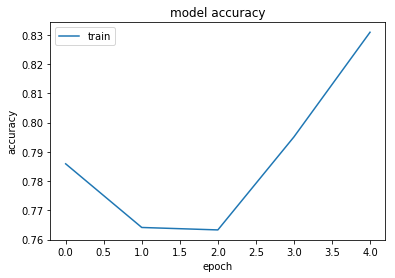

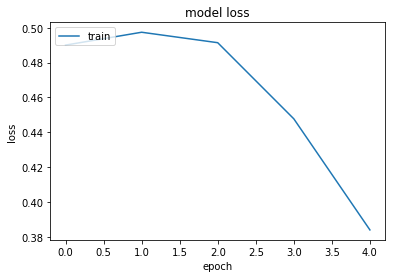

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'Validation'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()

#### Gerador de Predição
Gera previsões para as amostras de entrada de um gerador de dados. 

In [ ]:
y_train_pred = model.predict(X_train)
y_train_pred

array([[0.9700978 , 0.02990229],
       [0.02887085, 0.9711292 ],
       [0.96617204, 0.03382797],
       ...,
       [0.91973746, 0.08026256],
       [0.07519887, 0.9248011 ],
       [0.976702  , 0.02329802]], dtype=float32)

In [ ]:
y_train_results = []

for i in y_train_pred:
    print(i)
    y_pred = np.argmax(i)
    print(y_pred)
    y_train_results.append(lb.inverse_transform(y_pred))
y_train_results

[0.9700978  0.02990229]
0
[0.02887085 0.9711292 ]
1
[0.96617204 0.03382797]
0
[0.49052474 0.5094753 ]
1
[0.9726104  0.02738956]
0
[0.31519654 0.6848034 ]
1
[0.3402007  0.65979934]
1
[0.60079306 0.39920697]
0
[0.10873526 0.89126474]
1
[0.98000515 0.01999489]
0
[0.9834356  0.01656438]
0
[0.9697686  0.03023137]
0
[0.99302775 0.0069722 ]
0
[0.9806425  0.01935748]
0
[0.09780255 0.9021975 ]
1
[0.98486876 0.01513117]
0
[0.6144261  0.38557392]
0
[0.02593093 0.9740691 ]
1
[0.37224612 0.62775385]
1
[0.00201128 0.9979887 ]
1
[0.94602907 0.05397091]
0
[0.9762538  0.02374617]
0
[0.11113237 0.8888676 ]
1
[0.21589485 0.7841052 ]
1
[0.98736316 0.01263687]
0
[0.93362814 0.06637188]
0
[0.36536682 0.6346332 ]
1
[0.41345719 0.58654284]
1
[0.20293128 0.7970687 ]
1
[0.98342955 0.01657039]
0
[0.9537217  0.04627835]
0
[0.33419663 0.6658033 ]
1
[0.96048975 0.03951026]
0
[0.9779986  0.02200139]
0
[0.9304623  0.06953774]
0
[0.1831327 0.8168673]
1
[0.788997   0.21100305]
0
[0.21136028 0.7886397 ]
1
[0.9270314  0.

[array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Child'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array(['Adult'], dtype='<U5'),
 array([

In [ ]:
train_pred = model.predict_classes(X_train)
train_pred

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
test_pred = model.predict_classes(X_test)
test_pred

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
y_labels_test=np.argmax(y_test, axis=1)
y_labels_test[1]

1

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_labels_test, test_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      2472
           1       0.85      0.75      0.80      1645

    accuracy                           0.85      4117
   macro avg       0.85      0.83      0.84      4117
weighted avg       0.85      0.85      0.84      4117



In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_labels_test, test_pred)
matrix

array([[2259,  213],
       [ 418, 1227]])